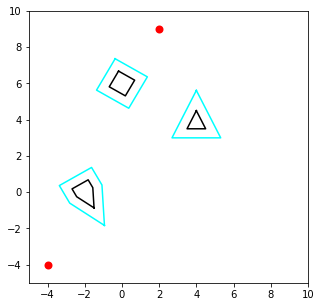

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
class Box2D:
    def __init__(self, x, y, yaw, corner_points=None, v=1.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.corner_points = corner_points
        self.inflat_cpoints = []
        self.v = v
    def update_once(self, dt):
        self.x += self.v*dt*math.cos(self.yaw)
        self.y += self.v*dt*math.sin(self.yaw)
    def inflation_obs(self, r):
        A = []
        for i in range(len(self.corner_points[0])-1):
            v1 = [self.corner_points[0, i], self.corner_points[1, i]]
            v2 = [self.corner_points[0, i+1], self.corner_points[1, i+1]]
            a = v2[0] - v1[0]
            b = v1[1] - v2[1]
            c = v1[1]*a+v1[0]*b
            inflat_c = -r*math.sqrt(a*a+b*b)+c
            A.append([a, b, inflat_c])
        pre_ind = -1
        for i in range(len(A)):
            a1, b1, c1 = A[pre_ind][1], A[pre_ind][0], A[pre_ind][2]
            a2, b2, c2 = A[i][1], A[i][0], A[i][2]
            x = (b2*c1-b1*c2)/(a1*b2-a2*b1)
            y = (a1*c2-a2*c1)/(a1*b2-a2*b1)  
            self.inflat_cpoints.append([x, y])
            pre_ind = i
        self.inflat_cpoints.append(self.inflat_cpoints[0])   
        self.inflat_cpoints = np.array(self.inflat_cpoints).T
        

corner_points3 = np.array([[0.5, -0.5, -0.5, 0.5],
                 [0.0, 0.5, -0.5, 0.0]])    
corner_points4 = np.array([[0.5, -0.5, -0.5, 0.5, 0.5],
                 [0.5, 0.5, -0.5, -0.5, 0.5]])       
corner_points5 = np.array([[1.0, 0.0, -0.5, -0.5, 0.0, 1.0],
                 [0.0, 0.5, 0.5, -0.5, -0.5, 0.0]])           
obs0 = Box2D(4.0, 4.0, math.pi/2.0, corner_points=corner_points3)
obs1 = Box2D(0.0, 6.0, math.pi/3.0, corner_points=corner_points4)
obs2 = Box2D(-2.0, 0.0, -math.pi/3.0, corner_points=corner_points5)
obs_buf = [obs0, obs1, obs2]
for obs in obs_buf:
    obs.inflation_obs(0.5)
def local2global(x0, y0, yaw0, corner_points):
    R = np.array([[math.cos(yaw0), -math.sin(yaw0)],
                  [math.sin(yaw0), math.cos(yaw0)]])
    corner_arr = np.array(corner_points)
    return np.dot(R, corner_arr)+np.array([[x0],[y0]])
plt.figure(figsize=(5, 5))

for obs in obs_buf:
    gcp = local2global(obs.x, obs.y, obs.yaw, obs.corner_points)
    plt.plot(gcp[0], gcp[1], 'k')
    inflat_cps = local2global(obs.x, obs.y, obs.yaw, obs.inflat_cpoints)
    plt.plot(np.array(inflat_cps)[0],np.array(inflat_cps)[1], 'cyan')
plt.scatter(-4.0, -4.0, color='red', linewidth=2)
plt.scatter(2.0, 9.0, color='red', linewidth=2)       
plt.axis([-5, 10, -5, 10])
plt.show()   

In [3]:
# time cost is 0.05774664878845215
def line_segment_cross_judge(Ax1, Ay1, Ax2, Ay2, Bx1, By1, Bx2, By2):
    if ((max(Ax1,Ax2)<=min(Bx1,Bx2) or min(Ax1,Ax2)>=max(Bx1,Bx2)) or
        (max(Ay1,Ay2)<=min(By1,By2) or min(Ay1,Ay2)>=max(By1,By2))):
        return False
    if (((Bx1-Ax1)*(Ay2-Ay1)-(By1-Ay1)*(Ax2-Ax1))*((Bx2-Ax1)*(Ay2-Ay1)-(By2-Ay1)*(Ax2-Ax1))<0 and
        ((Ax1-Bx1)*(By2-By1)-(Ay1-By1)*(Bx2-Bx1))*((Ax2-Bx1)*(By2-By1)-(Ay2-By1)*(Bx2-Bx1))<0):
        return True
    return False


ST_MAP = [[] for i in range(10)]
for obs in obs_buf:
    gcp0 = local2global(obs.x, obs.y, obs.yaw, obs.inflat_cpoints)
    for j in range(len(gcp0[0])-1):
        ST_MAP[0].append([gcp0[0][j], gcp0[1][j], gcp0[0][j+1], gcp0[1][j+1]])    
    for i in range(1, 10):
        for j in range(len(gcp0[0])-1):
            ST_MAP[i].append([gcp0[0][j], gcp0[1][j], gcp0[0][j+1], gcp0[1][j+1]])
        obs.update_once(1.0)
        gcp1 = local2global(obs.x, obs.y, obs.yaw, obs.inflat_cpoints)
        for j in range(len(gcp1[0])-1):
            ST_MAP[i].append([gcp1[0][j], gcp1[1][j], gcp1[0][j+1], gcp1[1][j+1]]) 
            ST_MAP[i].append([gcp0[0][j], gcp0[1][j], gcp1[0][j], gcp1[1][j]])   
        gcp0 = gcp1
        
  

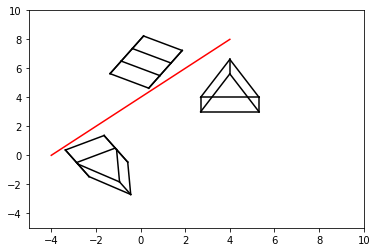

In [4]:
      
test_line = [-4.0, -0.0, 4.0, 8.0]        
        
Ax1, Ay1, Ax2, Ay2 = test_line        
for line in ST_MAP[1]:    
    Bx1, By1, Bx2, By2 = line
    if line_segment_cross_judge(Ax1, Ay1, Ax2, Ay2, Bx1, By1, Bx2, By2):
        print('is collision')
        break
        
for line in ST_MAP[1]:         
    plt.plot([line[0], line[2]], [line[1], line[3]], 'k')
plt.plot([test_line[0], test_line[2]], [test_line[1], test_line[3]], 'r')
plt.axis([-5, 10, -5, 10])    
plt.show()

ValueError: min() arg is an empty sequence

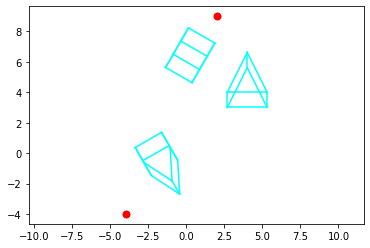

In [5]:
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
plt.figure(2)

for line in ST_MAP[1]:
    plt.plot([line[0], line[2]], [line[1], line[3]], 'cyan')
plt.scatter(-4.0, -4.0, color='red', linewidth=2)
plt.scatter(2.0, 9.0, color='red', linewidth=2)       
plt.axis([-8, 10, -8, 10])
plt.axis('equal')

class Node:
    def __init__(self, t, x, y):
        self.t = t
        self.x = x
        self.y = y
        self.cost = 0
        self.parent = -1
        
class AreaBounds:
    def __init__(self, area):
        self.xmin = float(area[0])
        self.xmax = float(area[1])
        self.ymin = float(area[2])
        self.ymax = float(area[3])
        
class STRRTStar(object):
    def __init__(self, start, goal, T, play_area, goal_sample_rate=5, expand_dis=3.0, max_iter=300):
        self.start = Node(0, start[0], start[1])
        self.end = Node(T, goal[0], goal[1])
        self.t_end = 0
        self.final_idx = -1
        self.T = T
        self.play_area = AreaBounds(play_area)
        self.goal_sample_rate = goal_sample_rate
        self.expand_dis = expand_dis
        self.max_iter = max_iter
        self.node_list = [self.start]
        self.layers_node_idxs = [[] for i in range(self.T)]
        self.layers_node_idxs[0].append(0)
        
    def planning(self):
        path = None
        i = 0
        while i < self.max_iter or self.final_idx < 0:
            t = self.sample_t()
            rnd_node = self.get_random_node(t)            
            nearest_ind = self.get_nearest_node_index(rnd_node, t)
            nearest_node = self.node_list[nearest_ind]
            new_node = self.steer(nearest_ind, rnd_node, self.expand_dis)
#             plt.plot([nearest_node.x, new_node.x], [nearest_node.y, new_node.y], 'b')
            if self.check_collision(nearest_node, new_node, t):
                self.t_end = min(self.T-1, t+1)
                self.node_list.append(new_node)
                self.layers_node_idxs[t+1].append(len(self.node_list)-1)
                plt.plot([nearest_node.x, new_node.x], [nearest_node.y, new_node.y], 'b')
                plt.scatter([nearest_node.x, new_node.x], [nearest_node.y, new_node.y], color='orange')
                
            if self.calc_dist_to_goal(self.node_list[-1].x, self.node_list[-1].y) <= self.expand_dis:
                final_node = self.steer(len(self.node_list)-1, self.end, self.expand_dis)
                if self.check_collision(self.node_list[-1], final_node, t):
                    self.node_list.append(final_node)
                    return self.generate_final_course() 
                
            if is_ipython:
                display.clear_output(wait=True)
                display.display(plt.gcf())                
            
    def sample_t(self):
        node_num_buf = [len(self.layers_node_idxs[i]) for  i in range(1, self.t_end+1) ]
        return  node_num_buf.index(min(node_num_buf))            
            
#     def sample_t(self):
#         while True:
#             t = random.randint(0, min(self.t_end, self.T-1))
#             if (len(self.layers_node_idxs[t+1]) < (t+1)*20):
#                 return t
    
    
    def get_random_node(self, t):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = Node(t+1, random.uniform(self.play_area.xmin, self.play_area.xmax),
                       random.uniform(self.play_area.ymin, self.play_area.ymax))
        else: rnd = Node(t+1, self.end.x, self.end.y)
        return rnd 
    
    
    def get_nearest_node_index(self, rnd_node, t):
        dlist = [(self.node_list[idx].x-rnd_node.x)**2+(self.node_list[idx].y-rnd_node.y)**2 for idx in self.layers_node_idxs[t]]
        return self.layers_node_idxs[t][dlist.index(min(dlist))]   
    
    
    def steer(self, from_ind, to_node, extend_length=float("inf")):
        from_node = self.node_list[from_ind]
        d, theta = self.calc_distance_and_angle(from_node, to_node)        
        
        if extend_length > d:
            extend_length = d
        
        new_node = Node(self.node_list[from_ind].t+1, from_node.x+extend_length * math.cos(theta),
                        from_node.y+extend_length * math.sin(theta))
        
        new_node.cost = self.calc_distance(self.node_list[from_ind], new_node) + self.node_list[from_ind].cost
        new_node.parent = from_ind
        return new_node 
    
    def calc_distance_and_angle(self, from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta 
    
    def calc_distance(self, from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        return math.hypot(dx, dy)    
    
    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)        
    
    def check_collision(self, node0, new_node, t):
        if new_node is None: return False
        Ax1, Ay1 = node0.x, node0.y
        Ax2, Ay2 = new_node.x, new_node.y
        for line in ST_MAP[t+1]:            
            Bx1, By1, Bx2, By2 = line
            if line_segment_cross_judge(Ax1, Ay1, Ax2, Ay2, Bx1, By1, Bx2, By2):
                return False
        return True
    
    def generate_final_course(self):
        path = [[self.end.x, self.end.y]]
        node = self.node_list[-1]
        while node.parent >= 0:
            path.append([node.x, node.y])
            node = self.node_list[node.parent]
        path.append([node.x, node.y])
        return list(reversed(path))   
    
start_pos = [-4.0, -4.0]
goal_pos = [2.0, 9.0]    
play_area = [-8, 10, -8, 10]
rrt = STRRTStar(start_pos, goal_pos, 20, play_area)
path = rrt.planning()
plt.plot(np.array(path)[:,0], np.array(path)[:,1], 'r')
plt.show()    
    

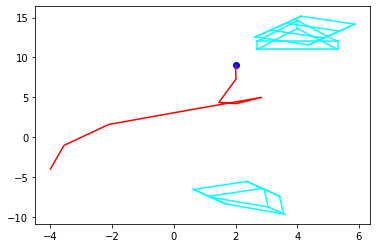

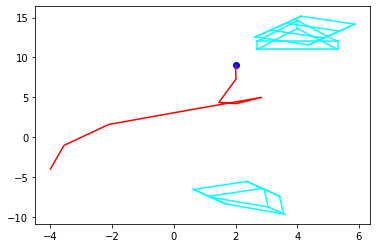

In [10]:
path = list(reversed(path)) 

for i in range(len(path)):
    plt.clf()
    plt.plot(np.array(path)[:,0], np.array(path)[:,1], 'r')
    plt.scatter(np.array(path)[i, 0], np.array(path)[i,1], color='blue')    
    for line in ST_MAP[i]:
        plt.plot([line[0], line[2]], [line[1], line[3]], 'cyan')
    import time
    time.sleep(1)
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())   